<a href="https://colab.research.google.com/github/erictong0/FrederickLab2023/blob/main/Linear%20Regression/Pixel%20Things/230629_30x30_Hand_made_optimization_Pixelated_Linear_regression_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# irrelevant

In [ ]:
#imports
!pip install bio --upgrade
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.3 MB/s eta 0:00:00


In [ ]:
#imports for timing things
!pip install line_profiler
%load_ext line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.9/661.9 kB 10.1 MB/s eta 0:00:00


In [ ]:
import sys
import glob
import math
import argparse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import csv
from matplotlib import colors
import re
import pandas as pd
from numpy import savetxt
from sklearn.linear_model import LinearRegression
from statistics import mean
import statsmodels.api as sm
from Bio.Data.IUPACData import protein_letters_1to3 as one2three
import scipy.optimize as spo
from pandas.core.internals.construction import ma
from sklearn.linear_model import Lasso

In [ ]:
#works to load information in variables before the program

fwhm = 2  # Full width at half maximum
# Calculate the standard deviation from the FWHM
c = fwhm / (2 * np.sqrt(2 * np.log(2)))

def get_row_floats(data, row):
  return list(map(lambda x: float(x[row]), data))

xArray = []
for i in range(68):
  b = i / 4 + 54
  xArray.append(np.linspace(b - 3 * c, b + 3 * c, 100))

oData = []
data = []
with open("T_10K.out", mode="r") as infile: #open data file and read contents
  reader = csv.reader(infile, delimiter="\n")
  for row in reader:
    if len(row) == 1:
      data.append(re.split('\t', row[0])[2:])
    else:
      data.append(row)

tempData = []
for i in range(6):
  tempData.append(np.array(get_row_floats(data[1:], i)))

oData.append(tempData)

data = []
tempData = []
count = 0
with open("spotlight 2022.csv", mode="r") as infile: #open data file and read contents
  chunk_size = 1000
  while True:
      chunk = infile.readlines(chunk_size)
      if not chunk:
        break
      for line in chunk:
        reader = csv.reader(infile)
        for row in reader:
          count += 1
          if len(row) == 1:
            tempData.append(re.split(r',', row[0]))
          else:
            tempData.append(row)

data.append(get_row_floats(tempData,0)[1:])
data.append(get_row_floats(tempData,1)[1:])

oData.append(data)

DATAINPUT = oData

In [ ]:
xScale = 30
yScale = 30

def main(inData, aa, rangeChoices):
  aa1 = aa

  phi = inData[0][0]
  psi = inData[0][1]
  ca = inData[0][2]
  cb = inData[0][3]
  c = inData[0][4]
  n = inData[0][5]



  ca_exp = inData[1][0] #def x as Ca shift
  intensity = inData[1][1]


  atom_key={
            "ca":0,
            "cb":1,
            "co":2,
            "n":3,
          }

  nonCys_nonGly_aas={"A", "D", "E", "F", "H", "I", "K", "L", "M",
                    "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}

  nonCys_aas={"A", "D", "E", "F", "G", "H", "I", "K", "L", "M",
              "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}

  na=np.nan

  aa_spec_ranges={ #ranges of interest for chemical shifts
                  #aa1 Ca      Cb      C         N
                  # Ca & Cb adjusted to 17ppm to match Fig5
                 'A':[[11,28],[203,234],[170,184],[112,133]],
                  'R':[[47,64],[22,39],[169,183],[112,133]],
                  'N':[[44,61],[30,47],[168,182],[106,127]],
                  'D':[[45,62],[33,50],[169,183],[109,130]],
  #               'C':[[50,67],[22,39],[168,182],[105,126]],
                  'Q':[[47,64],[22,39],[169,183],[108,129]],
                  'E':[[49,66],[22,39],[169,183],[109,130]],
                  'G':[[36,53],[203,234],[167,181],[ 98,119]],
                  'H':[[49,66],[23,40],[168,182],[107,128]],
                  'I':[[54,71],[31,48],[168,182],[109,130]],
                  'L':[[45,62],[33,50],[170,184],[110,131]],
                  'K':[[49,66],[26,43],[169,183],[109,130]],
                  'M':[[47,64],[26,43],[169,183],[108,129]],
                  'F':[[50,67],[31,48],[168,182],[107,128]],
                  'P':[[57,74],[25,42],[170,184],[ na, na]],
                  'S':[[50,67],[105,139],[55,72],[167,181],[104,125]],
                  'T':[[54,70],[104,138],[60,77],[168,182],[102,123]],
                  'W':[[48,65],[21,38],[169,183],[109,130]],
                  'Y':[[50,67],[30,47],[168,182],[108,129]],
                  'V':[[54,71],[25,42],[169,183],[108,129]],
                  }

  ####Changed this part####
  rchoice = rangeChoices

  ### extract plot subregions ###
  # "r" stands for ramachandran
  # regions: beta-strand, polyproline helix ii
  #          beta-turn I, alpha-helix,
  #          left handed helix (all phi > 0)
  # !!! top and left corner are always >= or <=
  #     unless they reach the bottom/right axis
  #     (i.e. betaB, ppiiB, left)

  #filter beta regions

  def makeMask(a, b, c, d):
    return np.logical_and(np.logical_and(phi >= a, phi <= b), np.logical_and(psi >= c, psi <= d))

  masks = {}
  datas = {}
  cs_ca = {}
  cs_cb = {}
  cs_co = {}

  for i in range(int(180/xScale)):
    for j in range(int(360/yScale)):
      name = f"{chr(i+65)}{(j+1):02d}"
      mask = makeMask(i*xScale-180, (i+1)*xScale-180, 180-(j+1)*yScale, 180-j*yScale)
      #print((i*10-180, i*10-170, 170-j*10, 180-j*10))
      cs_ca[name] = ca[mask]
      cs_cb[name] = cb[mask]
      cs_co[name] = c[mask]

  name = "rturni"
  mask = makeMask(0, 180, -180, 180)
  cs_ca[name] = ca[mask]
  cs_cb[name] = cb[mask]
  cs_co[name] = c[mask]
  #cs_ca = list(cs_ca) ???

  cs_all = {'ca':cs_ca,
            'cb':cs_cb,
            'c' :cs_co,
            }

  bin_width=0.25
  mtick_spacing=5
  #fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True,figsize=(10,10)) #35826579

  x_lims = np.array(aa_spec_ranges[aa1][0])
  y_lims = np.array(aa_spec_ranges[aa1][1])
  x_edges = np.arange(x_lims[0],x_lims[1]+bin_width,bin_width) #create an array from one limit to the next using bin widths
  y_edges=np.arange(y_lims[0],y_lims[1]+bin_width,bin_width)
  hw=bin_width/2
  center_bins_x=np.arange(x_lims[0]+hw,x_lims[1]+hw,bin_width)
  center_bins_y=np.arange(y_lims[0]+hw,y_lims[1]+hw,bin_width)
  inputs = []
  h_lists = []
  h_list = []
  c = fwhm / (2 * np.sqrt(2 * np.log(2)))
  for key in cs_ca:
    H, bins = np.histogram(cs_ca[key],bins=(x_edges),density=False)
    for j in range(len(H)):
      a = H[j]  # Maximum value
      b = bins[j]  # Peak position

      x = xArray[round(b*4-216)]

      # Calculate the y values for the curve using the Gaussian function
      y = a * np.exp(-(x - b)**2 / (2 * c**2))
      histogram, bins = np.histogram(x, bins=x_edges, density=False, weights = y)
      h_list.append(histogram)
    h_lists = sum(h_list)
    inputs.append(h_lists)
  H_exp, bins = np.histogram(ca_exp,bins=(x_edges),density=False, weights = intensity)
  target = (H_exp)

  tempRet = inputs
  tempArr = []
  for element in inputs:
    isSame = False
    for element2 in tempArr:
      if np.all(element == element2):
        isSame = True
    if isSame:
      pass
    else:
      tempArr.append(element)
  inputs = tempArr


  x = inputs
  y = target
  return (x, y, cs_ca, tempRet)


def func3P(dict):
  r, s, cs_ca, tempRet = main(DATAINPUT, "T", dict)
  #print(r.summary())
  return (r, s, cs_ca, tempRet)
  return (r.summary(), s, e)

x, y, cs_ca, rawInput = func3P({})
#resultString, cs_ca_list, H_exp = func3P({})



#Insert saved coefficients here


In [ ]:
print(np.shape(x))

(43, 64)


In [ ]:

copied = ""
coeff = [float(element) for element in copied.split()]

In [ ]:
coeff = [50] * 43

#After


In [ ]:
f = lambda x, y: ((x-y)**2)/x
tempCoeff = coeff
def resid2(c):
  global tempCoeff
  tempCoeff = c
  predictedY = [sum(element) for element in np.multiply(np.array(x).T, np.array(c))]
  total = sum(f(y, predictedY))
  return total


In [ ]:
#Actually optimizing things
for i in range(10):
  coeff = tempCoeff
  result = spo.least_squares(resid2, coeff, verbose = 2, max_nfev = 1000, bounds = (0, 100000000))
coeffArchive = tempCoeff
print(result.x)
print(result.fun)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6016e+17                                    1.33e+17    
       1              5         4.5860e+17      1.56e+15       1.05e+02       4.98e+16    
       2              6         4.5843e+17      1.77e+14       1.03e+02       4.21e+20    
       3             10         4.5838e+17      5.18e+13       5.12e+01       1.54e+16    
       4             11         4.5837e+17      2.75e+11       9.59e-02       1.53e+16    
       5             12         4.5837e+17      5.46e+11       1.92e-01       1.51e+16    
       6             13         4.5837e+17      1.08e+12       3.83e-01       1.48e+16    
       7             14         4.5837e+17      2.09e+12       7.66e-01       1.42e+16    
       8             15         4.5837e+17      3.94e+12       1.53e+00       1.30e+16    
       9             16         4.5836e+17      6.91e+12       3.03e+00       1.05e+16    

#Visualization


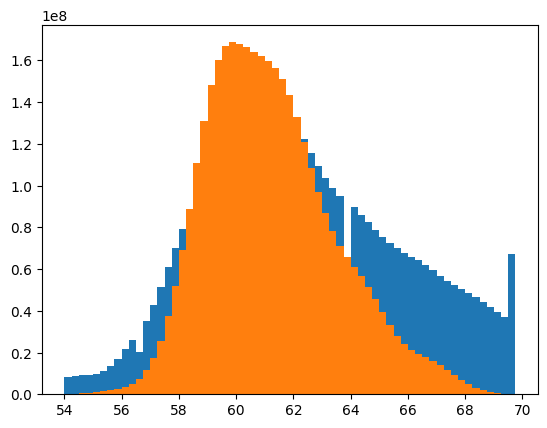

In [ ]:
plt.hist(np.arange(54,70,.25), bins = np.arange(54,70,.25), weights = y);
#print(np.shape(sum(np.multiply(np.array(x).T, coeff))));
plt.hist(np.arange(54, 70, .25), bins = np.arange(54, 70, .25), weights = sum(np.multiply(np.array(x).T, coeff).T));

In [ ]:
#makes a matplotlib rectangle object based on the coordinates of each corner.
def makeRect(s, c):
  return Rectangle((s[0], s[2]), s[1]-s[0], s[3]-s[2], color = c)

#takes a dictionary and plots all of the various rectangles
def visualizeRectangles(d, cs, r2):
  norm = colors.Normalize(-6e+03, 6e+03)


  fig, ax = plt.subplots()
  for key in d.keys():
    ax.add_patch(makeRect(d[key], cs[key]))

  bound = 180
  ax.set(xlim = (-1 * bound, bound), ylim = (-1*bound, bound))
  plt.xlabel("φ/phi (deg)")
  plt.ylabel("Ψ/psi (deg)")
  plt.title(f"Threonine Data: R²={round(r2, 3)}")
  fig.set_size_inches(6, 6)
  fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.RdBu))
  plt.show()

In [ ]:
print(coeff)

In [ ]:
print(np.all(rawInput[648] == x[235]))
#print(x[235])

#print(rawDict["R36"])
#print(x[235])
for key in rawDict.keys():
  if np.all(rawDict[key] == x[235]):
    print(key)

<ipython-input-29-586cb7bec796>:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.RdBu))


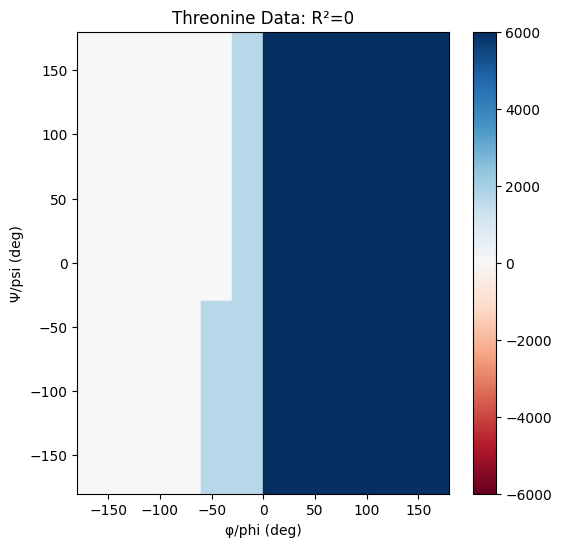

In [ ]:
norm = colors.Normalize(-6e+03, 6e+03)
rawDict = {}
visDict = {}
cDict = {}

for i in range(int(180/xScale)):
    for j in range(int(360/yScale)):
      name = f"{chr(i+65)}{(j+1):02d}"
      rawDict[name] = rawInput[i*int(360/yScale) + j]
      visDict[name] = (i*xScale-180, (i+1)*xScale-180, 180-(j+1)*yScale, 180-j*yScale)
rawDict["rlhelix"] = rawInput[int(360*180/xScale/yScale)]
visDict["rlhelix"] = (0, 180, -180, 180)
for i in range(len(x)):
  for key in rawDict.keys():
    if np.all(rawDict[key] == x[i]):
      cDict[key] = cm.RdBu(norm(coeff[i]))

#print(cDict)
visualizeRectangles(visDict, cDict, 0)

In [ ]:
norm = colors.Normalize(0, 4)
rawDict = {}
visDict = {}
cDict = {}

for i in range(int(180/xScale)):
    for j in range(int(360/yScale)):
      name = f"{chr(i+65)}{(j+1):02d}"
      rawDict[name] = rawInput[i*int(360/yScale) + j]
      visDict[name] = (i*xScale-180, (i+1)*xScale-180, 180-(j+1)*yScale, 180-j*yScale)
rawDict["rturn"] = rawInput[648]
visDict["rturn"] = (0, 180, -180, 180)
for i in range(len(x)):
  for key in rawDict.keys():
    if np.all(rawDict[key] == x[i]):
      cDict[key] = cm.RdBu(norm(np.log10(coeff[i])))

#print(cDict)
visualizeRectangles(visDict, cDict, 0)

In [ ]:
norm = colors.Normalize(-2.7e+07, 2.7e+07)
visDict = {}
colorArray = {}
valDict = {}
for i in range(int(180/xScale)):
  for j in range(int(360/yScale)):
    visDict[f"{chr(i+65)}{(j+1):02d}"] = (i*xScale-180, (i+1)*xScale-180, 180-(j+1)*yScale, 180-j*yScale)
    val = float(tempArr[int((i)*360/yScale + (j))][1])
    #print(f"{np.log(abs(val))} / {val}")
    valDict[f"{chr(i+65)}{(j+1):02d}"] = val
    colorArray[f"{chr(i+65)}{(j+1):02d}"] = cm.RdBu(norm(val))

visDict["rturni"] = (0, 180, -180, 180)
#print(visDict)
colorArray["rturni"] = cm.RdBu(float(tempArr[-1][1]))
#print(valDict)
visualizeRectangles(visDict, colorArray, float(r))

print(colorArray)


#otherVal = min(max(np.log(val*-1)*-1/4,0),1)
#otherVal = min(max(np.log(float(tempArr[-1][1]))*-1/4,0),1)

#for explaining process

In [ ]:
q = np.array(([1, 2], [3, 4], [5, 6]))
#print(q)

r = np.array((1, 2, 3))
#print(r)
#print(q.T)

print((np.multiply(q.T, r)))
print(sum(np.multiply(q.T, r).T))

In [ ]:
np.set_printoptions(threshold=np.inf)
print(np.shape(np.array(x)))
print(sum(np.multiply(np.array(x).T, coeff)))
np.set_printoptions(threshold=1000)